# 04 Evolución de la similitud a través del tiempo entre usuarios con intereses políticos
## Objetivo: computamos la similitud entre usuarios a través del tiempo para ver como fue su evolución.

Filtrando los usuarios que siguen a un único candidato a presidente, utilizamos una ventana de tiempo para tener múltiples matrices usuario-tópico, iguales a la que generamos en el **notebook 03**, y computar la  de los usuarios a través del tiempo.

Hacemos comparaciones intra-grupo, es decir, usuarios que siguen a un candidato contra ellos mismos, y luego computamos la  entre grupos, haciendo comparaciones de usuarios que siguen a un candidato contra usuarios que siguen a otro candidato.

In [1]:
import datetime
import sys
import os
import itertools

import pandas as pd
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix
from scipy.sparse import coo_matrix

import sklearn
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize

%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Colores de los politicos
macri_color = "#FFD700"
scioli_color = "#75AADB"
massa_color = "#3C3C3C"
stolbizer_color = "#EE4D8B"
random_color = "#DEB887"
difference_color = "#8B4513"
paso_date = datetime.datetime(2015,8,9)
first_round_date = datetime.datetime(2015, 10, 25)
second_round_date = datetime.datetime(2015, 11, 22)

x_ticks = [datetime.datetime(2015,8,1), datetime.datetime(2015,9,1), datetime.datetime(2015,10,1), datetime.datetime(2015,11,1),
   datetime.datetime(2015,12,1), datetime.datetime(2016,1,1), datetime.datetime(2016,2,1), datetime.datetime(2016,3,1)]
x_labels = ["Ago/15","Sep/15", "Oct/15","Nov/15", "Dic/15", "Ene/16", "Feb/16", "Mar/16", "Abr/16"]

# Parámetros de generación de la red de *hashtags*
- USAR_RETWEETS: usar hashtags provenientes de todos los tweets o únicamente aquellos que no fueron retweets
- UMBRAL: cantidad mínima de veces que coocurren dos hashtags en tweets para estar presentes en la búsqueda de topicos
- FILTRAR_ENTROPIA: aplicar filtro de entropía de aquellos hashtags que fueron usados por los cuatro grupos de seguidores de políticos mas uniformemente

# Parámetros de la evolución de similitud
- UMBRAL_TOPICOS: es la cantidad mínima de usos que debe tener el tópico para ser utilizado dentro de la evolución política de usuarios como una columna más del vector que representa al usuario.
- PERIODO : tamaño de la ventana de tiempo, en días, para hacer la evolución temporal de los usuarios
- FECHA_FIN: fecha de fin para la cual buscar hashtags publicados por usuarios

In [3]:
USAR_RETWEETS = False
UMBRAL = 3
FILTRAR_ENTROPIA = True

PERIODO = 10
UMBRAL_TOPICOS = 3
FECHA_INICIO = "2015-07-15 00:00:00"
FECHA_FIN = "2016-03-10 00:00:00"

In [4]:
hashtags = pd.read_csv('csv_files/hashtags.csv')
hashtags.head()

,id,hashtag
0,0,PasanteDeClarín
1,1,QueVuelvaElFav
2,2,NingunaSanta
3,3,Viernes
4,4,Velez


In [5]:
user_hashtags = pd.read_csv('csv_files/user_hashtags.csv')
user_hashtags.head()

,user_id,timestamp,hashtag
0,186068,2015-11-05 17:48:32,PasanteDeClarín
1,186068,2015-11-03 21:41:31,QueVuelvaElFav
2,186068,2015-10-25 15:03:35,NingunaSanta
3,186068,2015-10-24 05:49:57,Viernes
4,186068,2015-10-20 21:50:24,Velez


In [6]:
def extract_hashtag_topics():
    if (USAR_RETWEETS):
        return pd.read_csv('csv_files/hashtags_comunidades_'+str(UMBRAL)+'_entropia'+str(FILTRAR_ENTROPIA)+'.csv')
    else:
        return pd.read_csv('csv_files/hashtags_comunidades_'+str(UMBRAL)+'_entropia'+str(FILTRAR_ENTROPIA)+'_sin_retweets.csv')

def get_user_hashtag_topic():
    df = extract_hashtag_topics()
    grouped = df.groupby("cluster").count().reset_index()[["cluster", "id"]]
    grouped.columns = ["cluster", "topic_count"]
    grouped = grouped[grouped.topic_count >= UMBRAL_TOPICOS]
    df = df.merge(grouped)
    df = df.merge(hashtags)
    df = df.merge(user_hashtags)
    return df

In [7]:
if (USAR_RETWEETS):
    usuario_topico_df = get_user_hashtag_topic()
else:
    usuario_topico_df = get_user_hashtag_topic()
usuario_topico_df.shape

(8182756, 6)

In [8]:
usuario_topico_df.head()

,id,cluster,topic_count,hashtag,user_id,timestamp
0,10,673,38,Gol,186068,2015-10-15 01:42:09
1,10,673,38,Gol,77779,2015-09-26 14:06:21
2,10,673,38,Gol,77779,2015-09-26 14:03:52
3,10,673,38,Gol,257681,2015-09-19 19:23:18
4,10,673,38,Gol,294214,2015-08-12 03:29:42


In [9]:
gr = usuario_topico_df.groupby("cluster").count().reset_index().sort_values("id", ascending=False)
max_topics = gr[["id"]].iloc[0]["id"]
max_topics

1235517

In [10]:
gr.shape

(1396, 6)

In [11]:
remaining_topics = gr[gr["id"] >= (max_topics/128)][["cluster"]]
remaining_topics.shape

(124, 1)

In [12]:
usuario_topico_df = usuario_topico_df.merge(remaining_topics)
usuario_topico_df.shape

(6265905, 6)

In [13]:
usuario_topico_df.head()

,id,cluster,topic_count,hashtag,user_id,timestamp
0,14,1236,100,LaBarraTheWalkingDead,186068,2015-10-13 02:29:36
1,14,1236,100,LaBarraTheWalkingDead,118961,2015-11-03 02:11:44
2,14,1236,100,LaBarraTheWalkingDead,205142,2015-10-20 00:53:54
3,14,1236,100,LaBarraTheWalkingDead,205142,2015-10-13 13:32:41
4,14,1236,100,LaBarraTheWalkingDead,205424,2015-10-13 00:51:17


In [14]:
max_topic = usuario_topico_df.cluster.max() + 1

def get_df_grouping_keys(v):
    """La clave de agrupacion es el ID de usuario"""
    return pd.DataFrame(np.concatenate(v), columns=["user_id"])

def obtainDataframe(start_date, end_date):
    """Filtrar del DataFrame de utilizacion de usuario, topico,timestamp los usuarios y fechas correspondientes"""
    filtered = usuario_topico_df[(usuario_topico_df["timestamp"] >= start_date) & (usuario_topico_df["timestamp"] < end_date)]
    grouped = filtered.groupby(["user_id", "cluster"]).count().reset_index()[["user_id", "cluster", "timestamp"]]
    grouped.columns = ["user_id", "cluster", "count"]
    user_topic_matrix = coo_matrix((grouped["count"].values, \
            (grouped.user_id.values, grouped.cluster.values)),shape=(308170,max_topic))
    
    tfidf_transformer = TfidfTransformer()
    tfidf = tfidf_transformer.fit_transform(user_topic_matrix).tocoo()
    user_topic_df = pd.DataFrame(list(zip(tfidf.row, tfidf.col, tfidf.data)), columns=["user_id", "cluster", "count"])
    return user_topic_df

def get_user_topic_tfidf_matrix(user_topic_df, users):
    """De los usuarios y fechas filtrados, generar la matriz usuario topico para la ventana de tiempo"""
    keys = get_df_grouping_keys(users) # User filter
    ans_df = user_topic_df.merge(keys).groupby(["user_id", "cluster"]).sum().reset_index()
    if (not ans_df.empty):
        ans_df = ans_df[["user_id", "cluster", "count"]]
        ans = coo_matrix((ans_df["count"].values,(ans_df.user_id.values, ans_df.cluster.values)),\
            shape=(308170,max_topic))
    else:
        ans = coo_matrix((308170,max_topic))
    return ans.tocsr()

In [15]:
def extract_only_followers(follower_network, politician_id, except_politicians):
    """Extrae de la red de usuarios, aquellos usuarios que siguen a :param politician_id: y que NO siguen a ninguno de 
    los usuarios que estan dentro de :param except_politicians: """
    politician_followers = follower_network[follower_network["followed_id"] == politician_id].groupby("follower_id").count().reset_index().follower_id.values
    other_fols = follower_network[follower_network["followed_id"].isin(except_politicians)].follower_id.values
    filtered = [only for only in politician_followers if only not in other_fols]
    return filtered

In [16]:
macri_id = 137027
scioli_id = 188326
massa_id = 12218
stolbizer_id = 224325

In [17]:
follower_network = pd.read_csv('csv_files/followers.csv')

In [18]:
macri_followers = extract_only_followers(follower_network, macri_id, [scioli_id, massa_id, stolbizer_id])
scioli_followers = extract_only_followers(follower_network, scioli_id, [macri_id, massa_id, stolbizer_id])
massa_followers = extract_only_followers(follower_network, massa_id, [macri_id, scioli_id, stolbizer_id])
stolbizer_followers = extract_only_followers(follower_network, stolbizer_id, [macri_id, scioli_id, massa_id])

In [19]:
def generate_user_topic_dataframes(start_date = FECHA_INICIO, end_date = FECHA_FIN, 
        period_delta = 14):
    """Esta funcion genera filtra para una ventana de tiempo, los usuarios y los topicos sobre los cuales hablaron"""
    start_date = FECHA_INICIO
    end_date = FECHA_FIN
    i = datetime.datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
    d = datetime.datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
    j = d + datetime.timedelta(days=period_delta)
    directory = 'political_evolution_user_topic_df_' + str(period_delta)
    if (not os.path.isdir(directory)):
        os.mkdir(directory)
    while (str(i) <= end_date):
        user_topic_df = obtainDataframe(str(i), str(j))
        user_topic_df.to_csv(directory + "/df_" + str(i) + "_" + str(j) + ".csv", index=False)
        i += datetime.timedelta(days=1)
        j += datetime.timedelta(days=1)

def followers_vs_followers(followers, metric = np.mean, start_date = FECHA_INICIO, 
            end_date = FECHA_FIN, period_delta=14):
    """Esta funcion computa la similitud entre usuarios que siguen a un mismo candidato a traves del tiempo
    Utiliza los DataFrames generados previamente para una ventana de tiempo especifica"""
    directory = 'political_evolution_user_topic_df_' + str(period_delta)
    if (not os.path.isdir(directory)):
        generate_user_topic_dataframes(start_date, end_date, period_delta)
    vec = [[i] for i in followers]
    periods = []
    values = []
    i = datetime.datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
    d = datetime.datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
    j = d + datetime.timedelta(days=period_delta)
    while (str(i) <= end_date):
        df = pd.read_csv(directory + "/df_" + str(i) + "_" + str(j) + ".csv")
        user_mat = get_user_topic_tfidf_matrix(df, vec)
        num_personas = sum(user_mat.sum(axis=1).A1>0)
        sklearn.preprocessing.normalize(user_mat, copy=False)
        data = sp.triu(user_mat.dot(user_mat.T), k=1).data
        if (metric is None):
            month = (i + datetime.timedelta(days=(period_delta / 2))).replace(day=1)
            periods = np.concatenate((periods, np.repeat(month, len(data))))
            values = np.concatenate((values, data))
        else:
            if (len(data) != 0):
                values.append(metric(data))
            else:
                values.append(0)
            periods.append(i + datetime.timedelta(days=(period_delta / 2)))
        i += datetime.timedelta(days=1)
        j += datetime.timedelta(days=1)
    if (metric is None):
        return pd.DataFrame(list(zip(periods,values)), columns=["fecha", "valor"])
    else:
        return values, periods

In [20]:
non_nulls = usuario_topico_df.groupby("user_id").count().reset_index()[["user_id"]]
def get_random_user_ids(n=10000):
    df = non_nulls.sample(n=n)
    return df.user_id.values.tolist()

In [21]:
generate_user_topic_dataframes(period_delta=PERIODO)

### Estadístico aplicado: Media

In [22]:
scioli_val, scioli_per = followers_vs_followers(scioli_followers, metric = np.mean,period_delta=PERIODO, end_date=FECHA_FIN)
scioli_s = pd.Series(scioli_val, index=scioli_per)

In [23]:
macri_val, macri_per = followers_vs_followers(macri_followers, metric = np.mean,period_delta=PERIODO, end_date=FECHA_FIN)
macri_s = pd.Series(macri_val, index=macri_per)

In [24]:
massa_val, massa_per = followers_vs_followers(massa_followers, metric = np.mean,period_delta=PERIODO, end_date=FECHA_FIN)
massa_s = pd.Series(massa_val, index=massa_per)

In [25]:
stolbizer_val, stolbizer_per = followers_vs_followers(stolbizer_followers, metric = np.mean,period_delta=PERIODO, end_date=FECHA_FIN)
stolbizer_s = pd.Series(stolbizer_val, index=stolbizer_per)

In [26]:
random_val, random_per = followers_vs_followers(followers=get_random_user_ids(10000),metric=np.mean, period_delta=PERIODO, end_date=FECHA_FIN)
random_s = pd.Series(random_val, index=random_per)

In [27]:
def followers_vs_OTHER_followers(followers1, followers2, metric = np.mean, start_date = FECHA_INICIO, 
            end_date = FECHA_FIN, period_delta=14):
    """Esta funcion computa la similitud entre usuarios que siguen a un candidato contra usuarios que siguen a otro
    candidato. Utiliza los DataFrames generados previamente para una ventana de tiempo especifica"""
    directory = 'csv_files/political_evolution_user_topic_df_' + str(period_delta)
    if (not os.path.isdir(directory)):
        generate_user_topic_dataframes(start_date, end_date, period_delta)
    vec1 = [[i] for i in followers1]
    vec2 = [[i] for i in followers2]
    periods = []
    values = []
    i = datetime.datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
    d = datetime.datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
    j = d + datetime.timedelta(days=period_delta)
    while (str(i) <= end_date):
        df = pd.read_csv(directory + "/df_" + str(i) + "_" + str(j) + ".csv")
        user_mat1 = get_user_topic_tfidf_matrix(df, vec1)
        user_mat2 = get_user_topic_tfidf_matrix(df, vec2)
        sklearn.preprocessing.normalize(user_mat1, copy=False)
        sklearn.preprocessing.normalize(user_mat2, copy=False)
        data = user_mat1.dot(user_mat2.T).data
        if (metric is None):
            month = (i + datetime.timedelta(days=(period_delta / 2))).replace(day=1)
            periods = np.concatenate((periods, np.repeat(month, len(data))))
            values = np.concatenate((values, data))
        else:
            if (len(data) != 0):
                values.append(metric(data))
            else:
                values.append(0)
            periods.append(i + datetime.timedelta(days=(period_delta / 2)))
        i += datetime.timedelta(days=1)
        j += datetime.timedelta(days=1)
    if (metric is None):
        return pd.DataFrame(list(zip(periods,values)), columns=["fecha", "valor"])
    else:
        return values, periods

# Gráficos

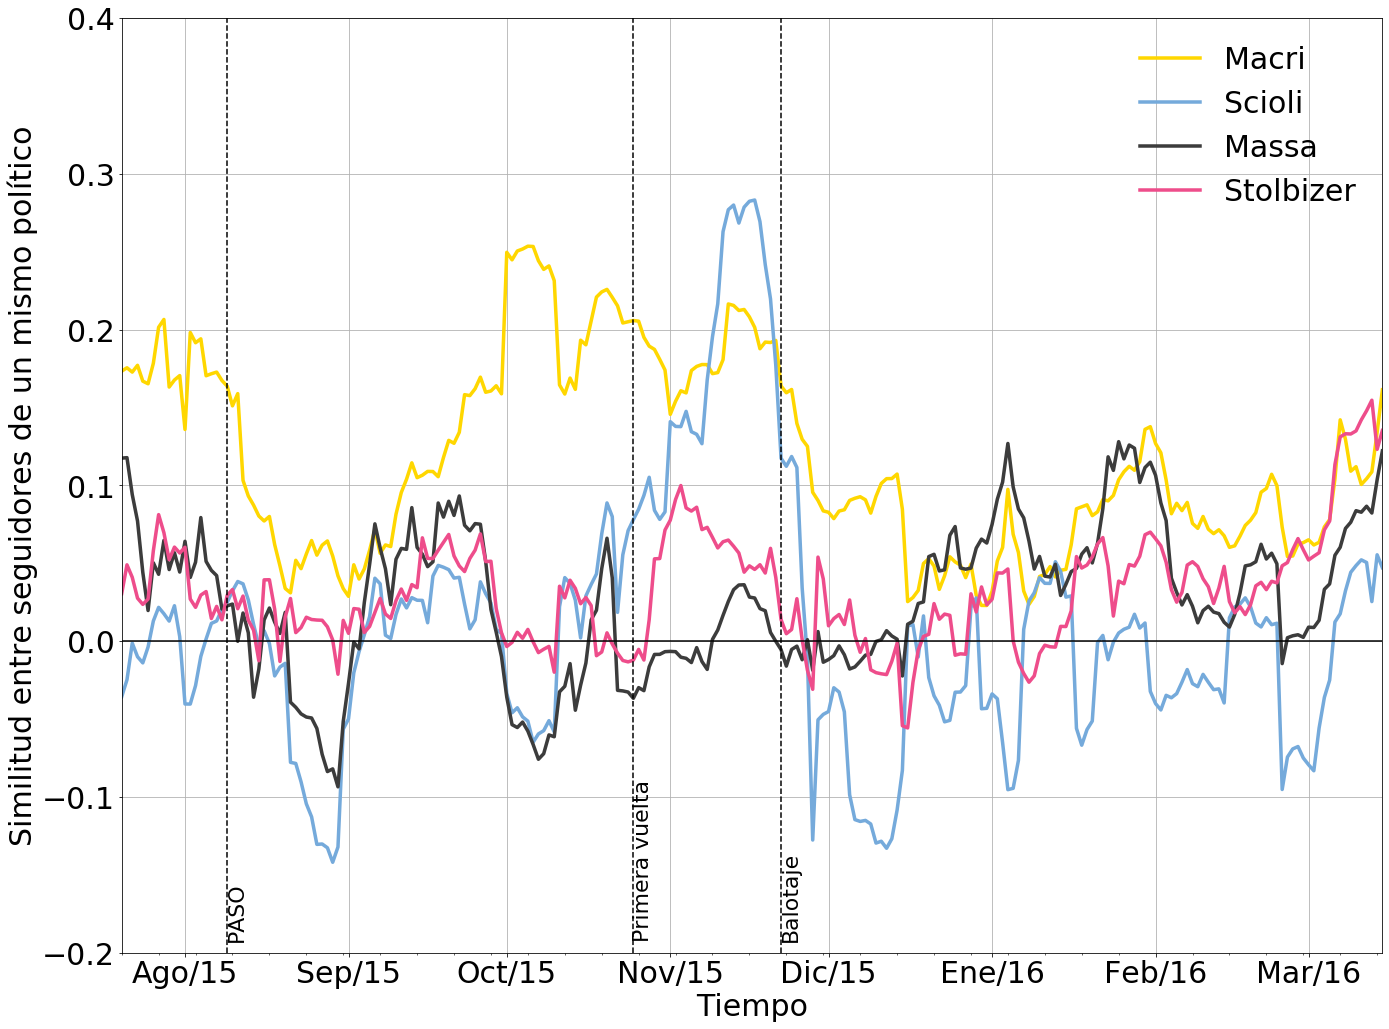

In [28]:
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = [20, 15]
w = 3.5
y_min = -0.2
(macri_s - random_s).plot(label="Macri", color=macri_color, linewidth=w)
(scioli_s - random_s).plot(label="Scioli", color=scioli_color, linewidth=w)
(massa_s - random_s).plot(label="Massa", color=massa_color, linewidth=w)
(stolbizer_s - random_s).plot(label="Stolbizer", color=stolbizer_color, linewidth=w)
plt.axvline(paso_date, color="Black",linestyle='dashed')
plt.axvline(first_round_date, color="Black",linestyle='dashed')
plt.axvline(second_round_date, color="Black",linestyle='dashed')
plt.text(paso_date,y_min + 0.01,"PASO",rotation=90, fontsize=22)
plt.text(first_round_date,y_min + 0.01,"Primera vuelta",rotation=90, fontsize=22)
plt.text(second_round_date,y_min + 0.01,"Balotaje",rotation=90, fontsize=22)
plt.legend(frameon=False)
plt.xlabel("Tiempo")
plt.xticks(x_ticks, x_labels)
plt.ylim(y_min,0.4)
plt.ylabel(u"Similitud entre seguidores de un mismo político")
plt.tight_layout()
plt.grid()
plt.axhline(0, color="Black", linestyle="solid")
plt.show()

In [29]:
vals, periods = followers_vs_OTHER_followers(macri_followers, scioli_followers, end_date = FECHA_FIN, period_delta=PERIODO, metric=np.mean)
macri_scioli_s = pd.Series(vals, index=periods)

vals, periods = followers_vs_OTHER_followers(macri_followers, massa_followers, end_date = FECHA_FIN, period_delta=PERIODO, metric=np.mean)
macri_massa_s = pd.Series(vals, index=periods)

vals, periods = followers_vs_OTHER_followers(scioli_followers, massa_followers, end_date = FECHA_FIN, period_delta=PERIODO, metric=np.mean)
scioli_massa_s = pd.Series(vals, index=periods)

vals, periods = followers_vs_OTHER_followers(macri_followers, stolbizer_followers, end_date = FECHA_FIN, period_delta=PERIODO, metric=np.mean)
macri_stolbizer_s = pd.Series(vals, index=periods)

vals, periods = followers_vs_OTHER_followers(scioli_followers, stolbizer_followers, end_date = FECHA_FIN, period_delta=PERIODO, metric=np.mean)
scioli_stolbizer_s = pd.Series(vals, index=periods)

vals, periods = followers_vs_OTHER_followers(massa_followers, stolbizer_followers, end_date = FECHA_FIN, period_delta=PERIODO, metric=np.mean)
massa_stolbizer_s = pd.Series(vals, index=periods)

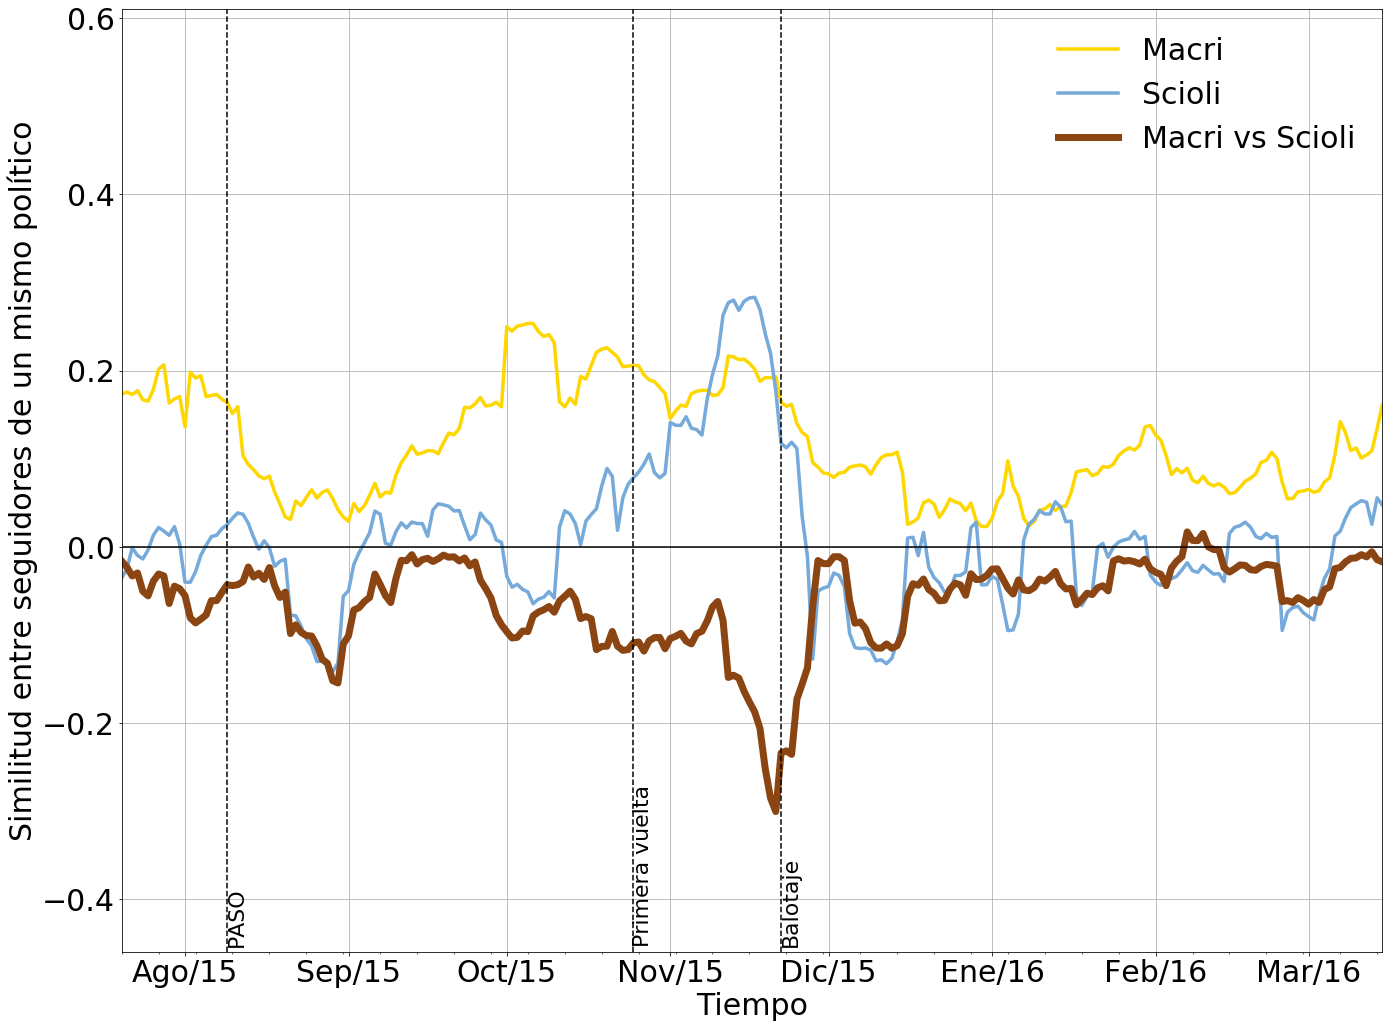

In [30]:
# Plotting
w = 3.5
y_min = -0.46
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = [20, 15]
(macri_s - random_s).plot(label= "Macri", color=macri_color, linewidth=w)
(scioli_s - random_s).plot(label= "Scioli", color=scioli_color, linewidth=w)
(macri_scioli_s - random_s).plot(label="Macri vs Scioli", color=difference_color, linewidth=w*2)
plt.axvline(paso_date, color="Black",linestyle='dashed')
plt.axvline(first_round_date, color="Black",linestyle='dashed')
plt.axvline(second_round_date, color="Black",linestyle='dashed')
plt.text(paso_date,y_min + 0.01,"PASO",rotation=90, fontsize=22)
plt.text(first_round_date,y_min + 0.01,"Primera vuelta",rotation=90, fontsize=22)
plt.text(second_round_date,y_min + 0.01,"Balotaje",rotation=90, fontsize=22)
plt.legend(frameon=False)
plt.ylim(y_min,0.61)
plt.xticks(x_ticks, x_labels)
plt.xlabel("Tiempo")
plt.ylabel(u"Similitud entre seguidores de un mismo político")
plt.tight_layout()
plt.grid()
plt.axhline(0, color="Black", linestyle="solid")
plt.show()

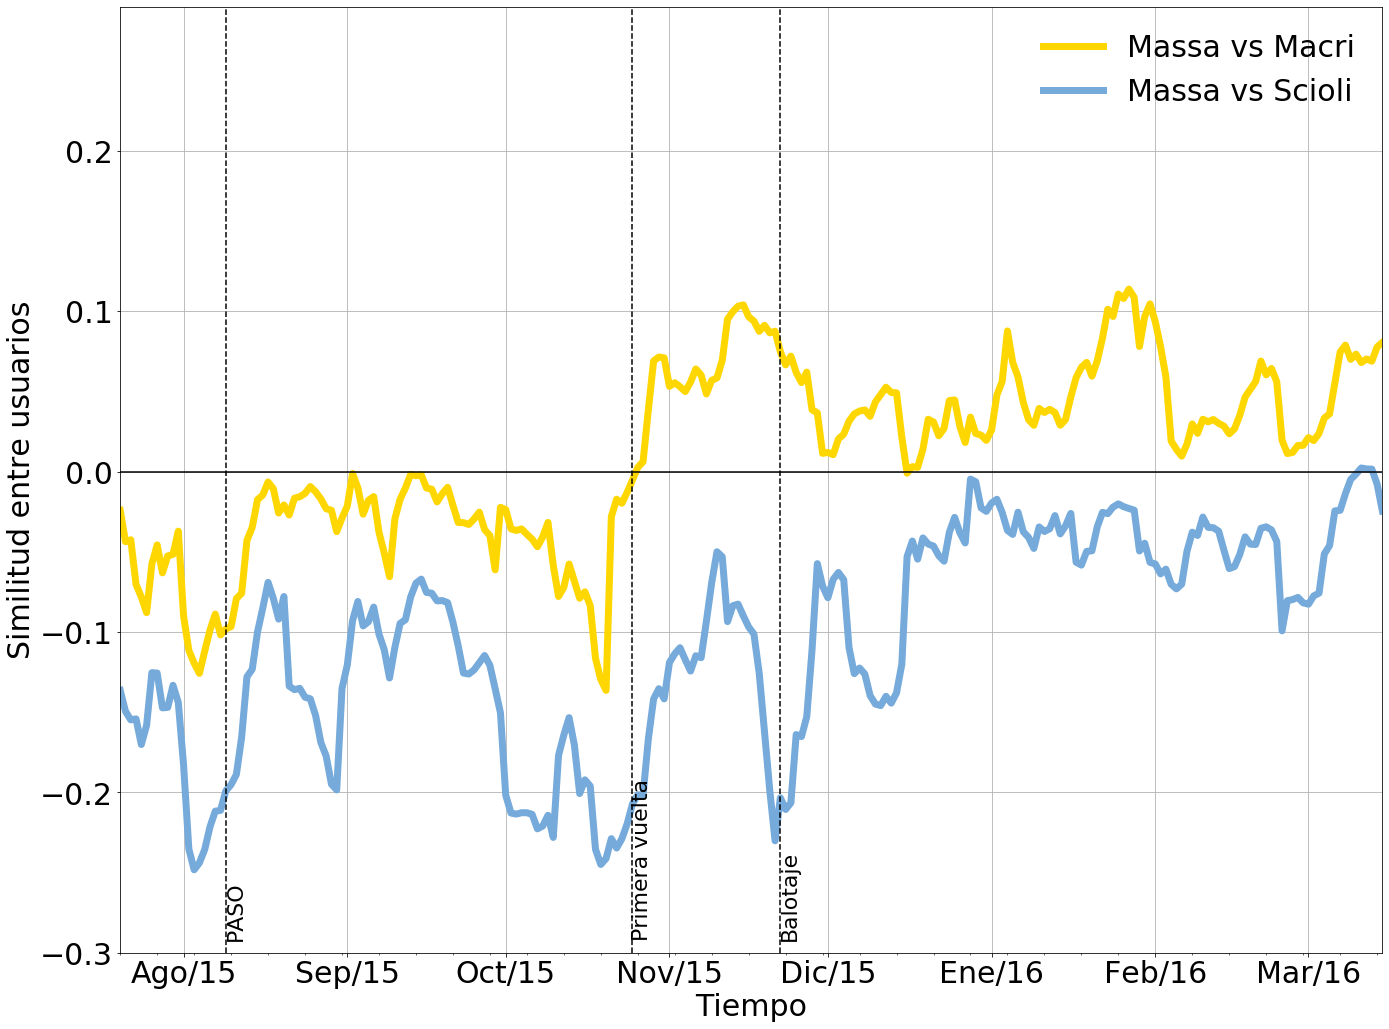

In [31]:
# Massa vs Scioli y Massa vs Macri
y_min = -0.3
w = 3.5
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = [20, 15]

(macri_massa_s - random_s).plot(label="Massa vs Macri", color=macri_color, linewidth=w*2)
(scioli_massa_s - random_s).plot(label= "Massa vs Scioli", color=scioli_color, linewidth=w*2)
plt.axvline(paso_date, color="Black",linestyle='dashed')
plt.axvline(first_round_date, color="Black",linestyle='dashed')
plt.axvline(second_round_date, color="Black",linestyle='dashed')
plt.text(paso_date,y_min + 0.01,"PASO",rotation=90, fontsize=22)
plt.text(first_round_date,y_min + 0.01,"Primera vuelta",rotation=90, fontsize=22)
plt.text(second_round_date,y_min + 0.01,"Balotaje",rotation=90, fontsize=22)
plt.ylim(y_min,0.29)
plt.legend(frameon=False)
plt.xticks(x_ticks, x_labels)
plt.xlabel("Tiempo")
plt.ylabel("Similitud entre usuarios")
plt.tight_layout()
plt.grid()
plt.axhline(0, color="Black", linestyle="solid")
plt.plot()
plt.show()

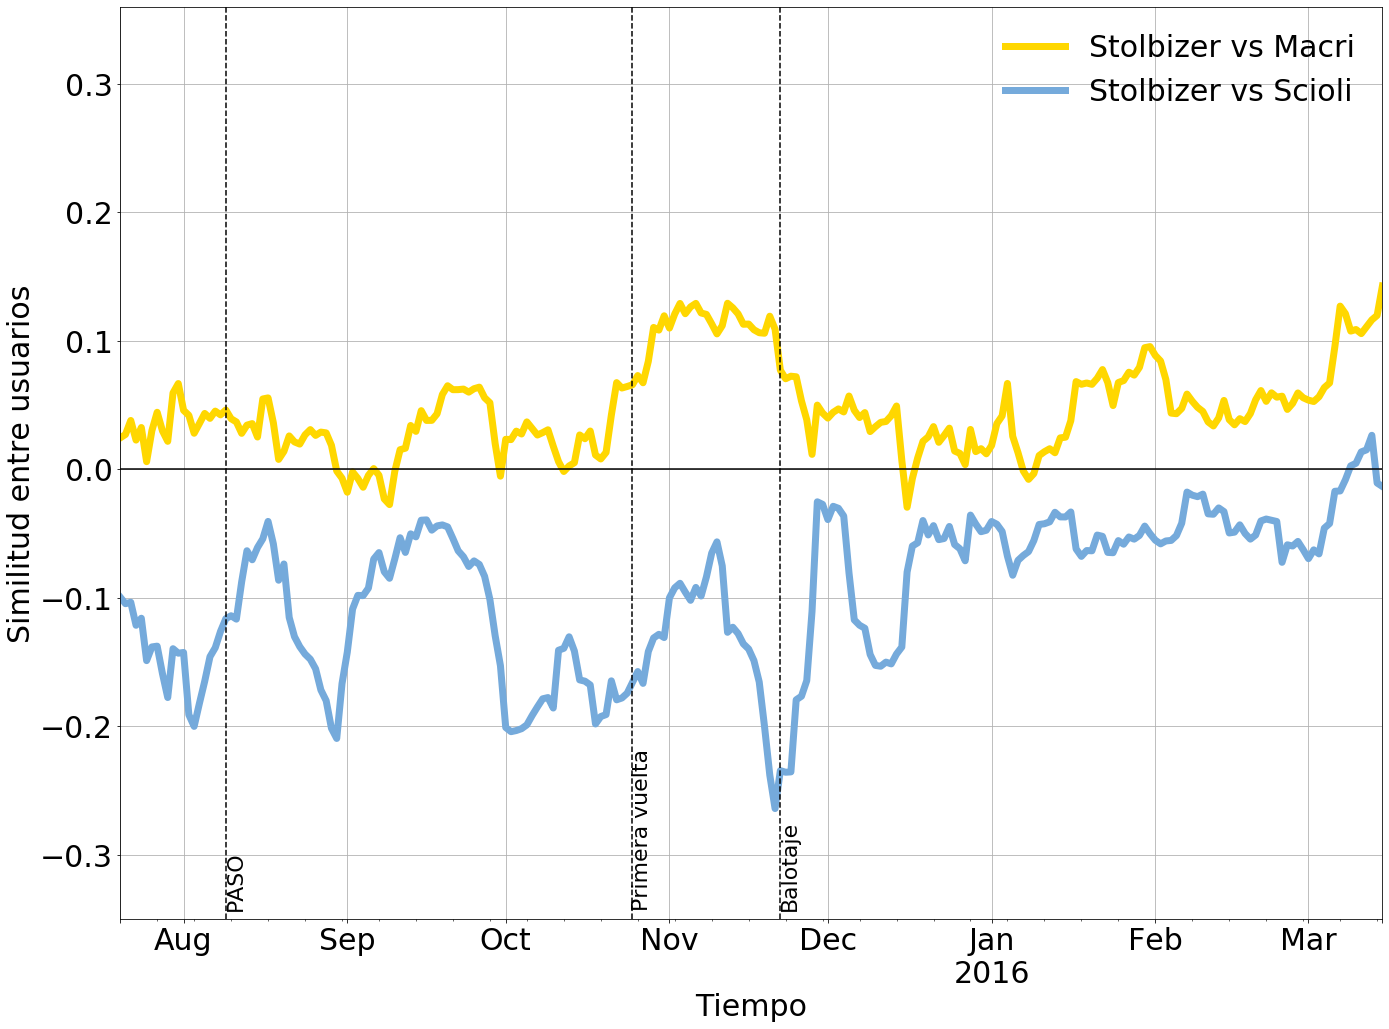

In [32]:
# Stolbizer vs Scioli y Stolbizer vs Macri
w = 3.5
y_min = -0.35
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = [20, 15]
(macri_stolbizer_s - random_s).plot(label="Stolbizer vs Macri", color=macri_color, linewidth=w*2)
(scioli_stolbizer_s - random_s).plot(label= "Stolbizer vs Scioli", color=scioli_color, linewidth=w*2)
plt.axvline(paso_date, color="Black",linestyle='dashed')
plt.axvline(first_round_date, color="Black",linestyle='dashed')
plt.axvline(second_round_date, color="Black",linestyle='dashed')
plt.text(paso_date,y_min + 0.01,"PASO",rotation=90, fontsize=22)
plt.text(first_round_date,y_min + 0.01,"Primera vuelta",rotation=90, fontsize=22)
plt.text(second_round_date,y_min + 0.01,"Balotaje",rotation=90, fontsize=22)
plt.ylim(y_min,0.36)
plt.legend(frameon=False)
plt.xlabel("Tiempo")
plt.ylabel("Similitud entre usuarios")
plt.tight_layout()
plt.grid()
plt.axhline(0, color="Black", linestyle="solid")
plt.plot()
plt.show()

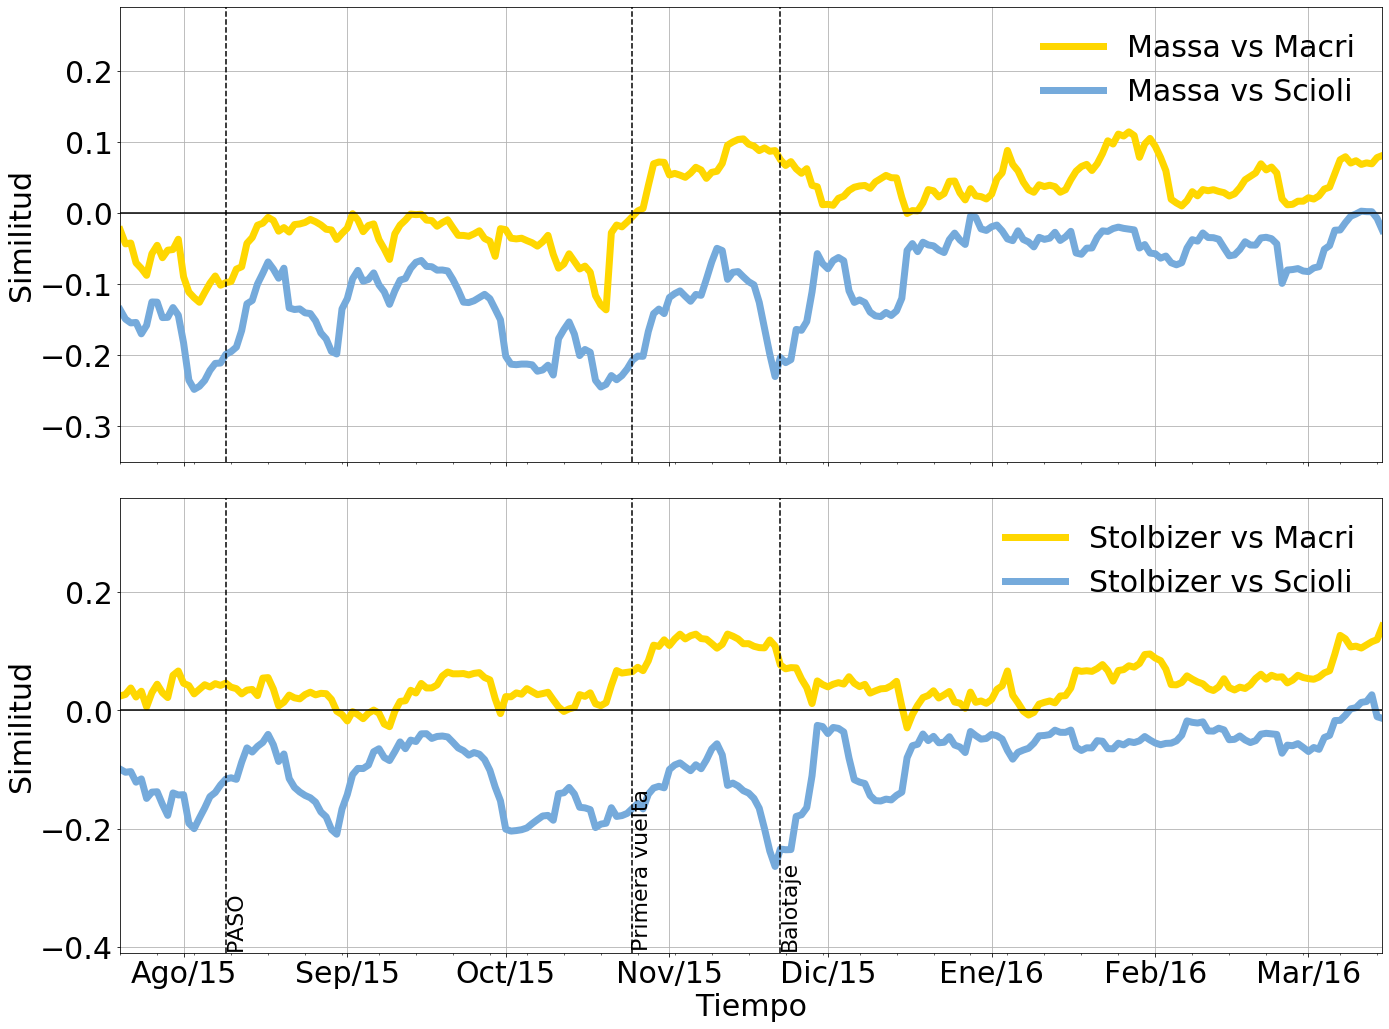

In [33]:
w = 3.5
y_lim = -0.375
y_lim2 = -0.41

plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = [20, 15]
plt.subplot(2,1,1)
(macri_massa_s - random_s).plot(label="Massa vs Macri", color=macri_color, linewidth=w*2)
(scioli_massa_s - random_s).plot(label= "Massa vs Scioli", color=scioli_color, linewidth=w*2)
plt.axvline(paso_date, color="Black",linestyle='dashed')
plt.axvline(first_round_date, color="Black",linestyle='dashed')
plt.axvline(second_round_date, color="Black",linestyle='dashed')
plt.xticks(x_ticks, ['' for i in range(len(x_ticks))])
plt.ylim(y_min,0.29)
plt.legend(frameon=False)
plt.ylabel("Similitud")
plt.tight_layout()
plt.grid()
plt.axhline(0, color="Black", linestyle="solid")

plt.subplot(2,1,2)
(macri_stolbizer_s - random_s).plot(label="Stolbizer vs Macri", color=macri_color, linewidth=w*2)
(scioli_stolbizer_s - random_s).plot(label= "Stolbizer vs Scioli", color=scioli_color, linewidth=w*2)
plt.axvline(paso_date, color="Black",linestyle='dashed')
plt.axvline(first_round_date, color="Black",linestyle='dashed')
plt.axvline(second_round_date, color="Black",linestyle='dashed')
plt.text(paso_date,y_lim2 + 0.01,"PASO",rotation=90, fontsize=22)
plt.text(first_round_date,y_lim2 + 0.01,"Primera vuelta",rotation=90, fontsize=22)
plt.text(second_round_date,y_lim2 + 0.01,"Balotaje",rotation=90, fontsize=22)

plt.xticks(x_ticks, x_labels)
plt.ylim(y_lim2,0.36)
plt.legend(frameon=False)
plt.xlabel("Tiempo")
plt.ylabel("Similitud")
plt.tight_layout()
plt.grid()
plt.axhline(0, color="Black", linestyle="solid")
plt.plot()
plt.show()

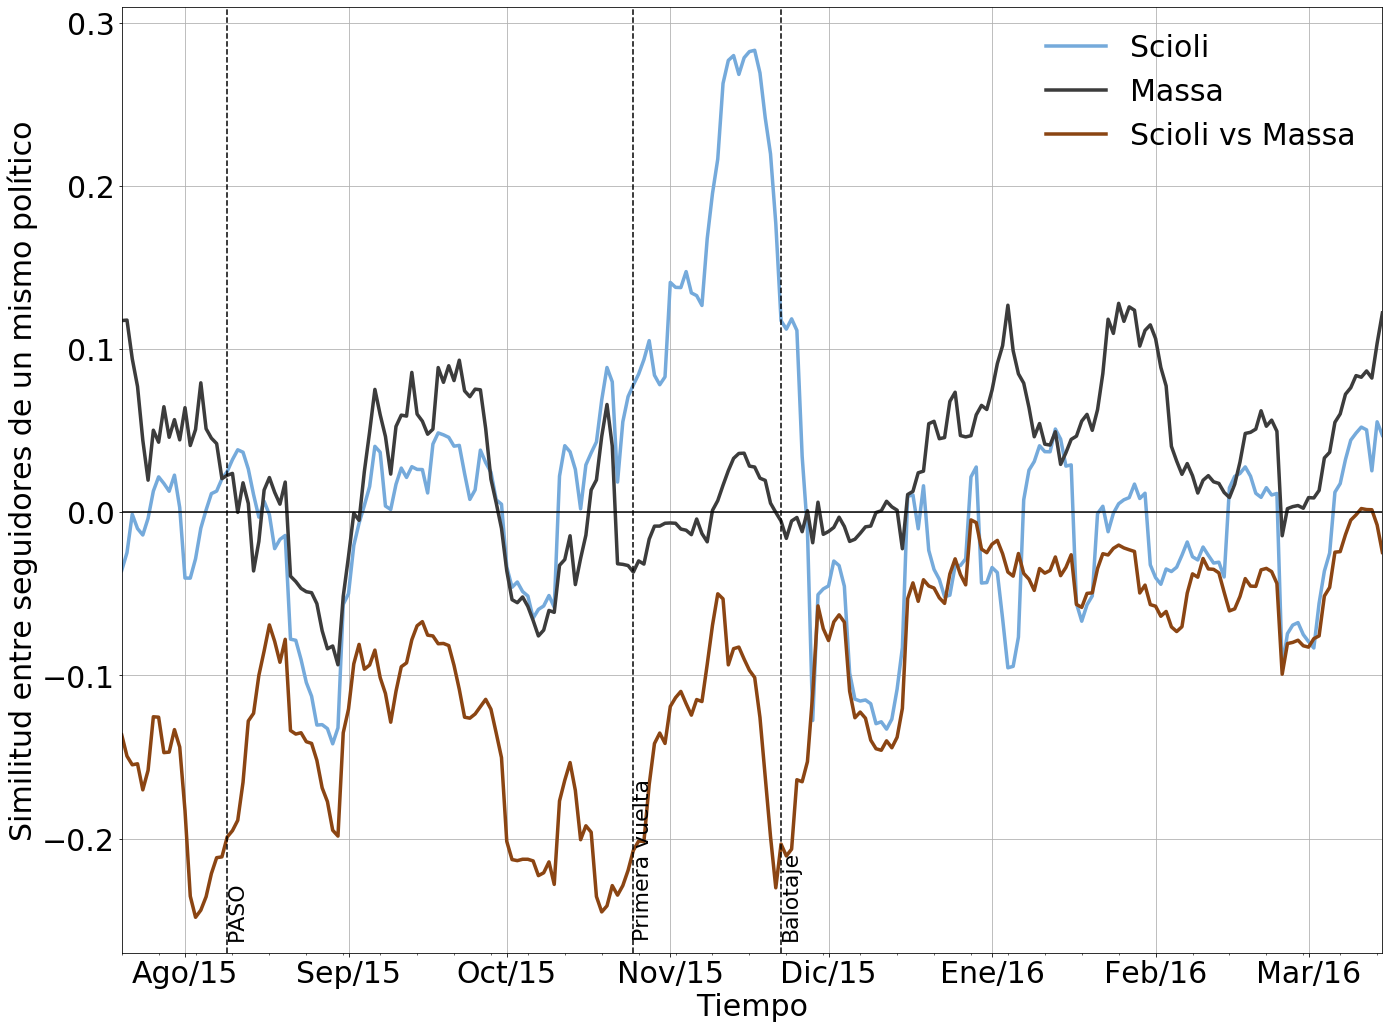

In [34]:
#Scioli vs Massa
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = [20, 15]
w = 3.5
y_min = -0.27
(scioli_s - random_s).plot(label="Scioli", color=scioli_color, linewidth=w)
(massa_s - random_s).plot(label="Massa", color=massa_color, linewidth=w)
(scioli_massa_s - random_s).plot(label="Scioli vs Massa", color=difference_color, linewidth=w)
plt.axvline(paso_date, color="Black",linestyle='dashed')
plt.axvline(first_round_date, color="Black",linestyle='dashed')
plt.axvline(second_round_date, color="Black",linestyle='dashed')
plt.text(paso_date,y_min + 0.01,"PASO",rotation=90, fontsize=22)
plt.text(first_round_date,y_min + 0.01,"Primera vuelta",rotation=90, fontsize=22)
plt.text(second_round_date,y_min + 0.01,"Balotaje",rotation=90, fontsize=22)
plt.legend(frameon=False)
plt.xlabel("Tiempo")
plt.xticks(x_ticks, x_labels)
plt.ylim(y_min,0.31)
plt.ylabel(u"Similitud entre seguidores de un mismo político")
plt.tight_layout()
plt.grid()
plt.axhline(0, color="Black", linestyle="solid")
plt.show()

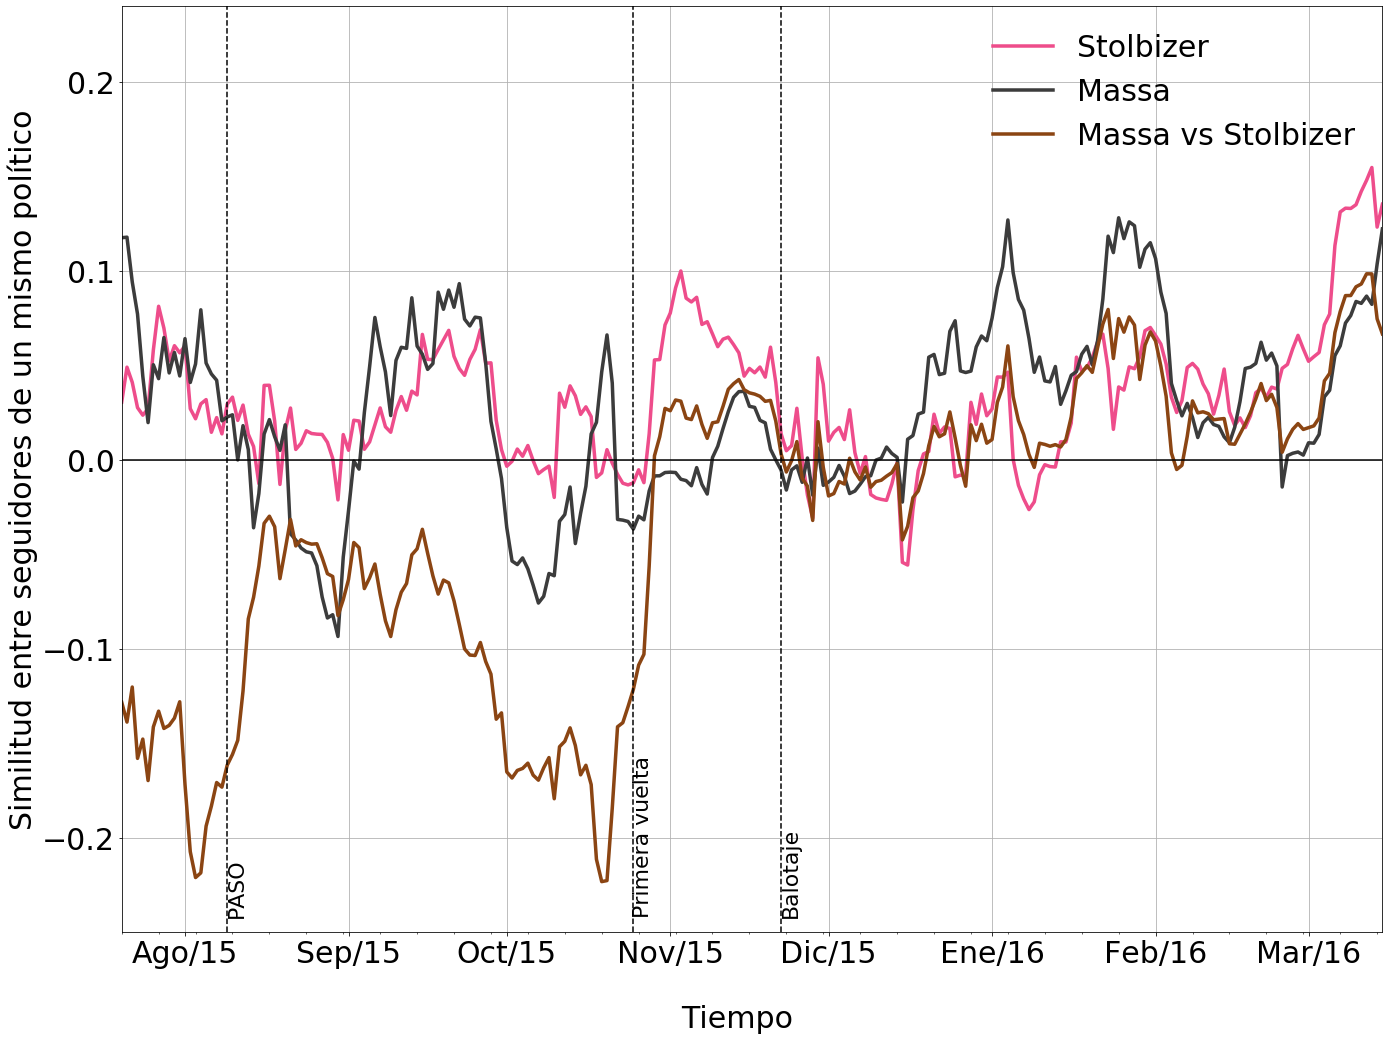

In [35]:
#Massa vs Stolbizer
plt.rcParams.update({'font.size': 30})
plt.rcParams['figure.figsize'] = [20, 15]
w = 3.5
y_min = -0.25
(stolbizer_s - random_s).plot(label="Stolbizer", color=stolbizer_color, linewidth=w)
(massa_s - random_s).plot(label="Massa", color=massa_color, linewidth=w)
(massa_stolbizer_s - random_s).plot(label="Massa vs Stolbizer", color=difference_color, linewidth=w)
plt.axvline(paso_date, color="Black",linestyle='dashed')
plt.axvline(first_round_date, color="Black",linestyle='dashed')
plt.axvline(second_round_date, color="Black",linestyle='dashed')
plt.text(paso_date,y_min + 0.01,"PASO",rotation=90, fontsize=22)
plt.text(first_round_date,y_min + 0.01,"Primera vuelta",rotation=90, fontsize=22)
plt.text(second_round_date,y_min + 0.01,"Balotaje",rotation=90, fontsize=22)
plt.legend(frameon=False)
plt.xticks(x_ticks, x_labels)
plt.text(datetime.datetime(2015, 11, 3),-0.3,"Tiempo")
plt.ylim(y_min,0.24)
plt.ylabel(u"Similitud entre seguidores de un mismo político")
plt.tight_layout()
plt.grid()
plt.axhline(0, color="Black", linestyle="solid")
plt.show()